# Auswahl von Merkmalen
Bei der Auswahl der richtigen Merkmale gibt es einige Faustregeln, die man berücksichtigen kann. Zum Beispiel sollten kleine Radius- / Sigma-Werte verwendet werden, wenn man Objekte sehr präzise segmentieren möchte. Wenn eine grobe Kontur ausreicht oder einzelne Pixel an den Objektgrenzen eliminiert werden sollen, ist es sinnvoll, größere Radius- und Sigma-Werte zu verwenden. Dieses Thema kann jedoch auch mit Hilfe von Statistiken angegangen werden.

In [1]:
from skimage.io import imread, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
import matplotlib.pyplot as plt
import pandas as pd

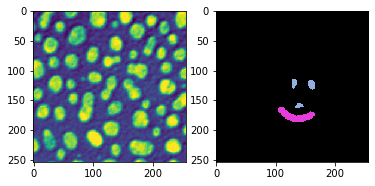

In [2]:
image = imread('../../data/blobs.tif')

manual_annotation = imread('../../data/blobs_annotations.tif')

fig, axs = plt.subplots(1,2)

cle.imshow(image, plot=axs[0])
cle.imshow(manual_annotation, labels=True, plot=axs[1])

## Training - mit zu vielen Merkmalen
Wir trainieren jetzt einen Objektsegmentierer und stellen viele Merkmale zur Verfügung. Wir müssen auch Parameter angeben, um tiefe Entscheidungsbäume und viele Bäume zu konfigurieren. Dies ist notwendig, damit die nächsten Schritte, die Ableitung von Statistiken, genügend statistische Aussagekraft haben.
Anschließend werfen wir einen Blick auf das Ergebnis für eine schnelle Plausibilitätsprüfung.

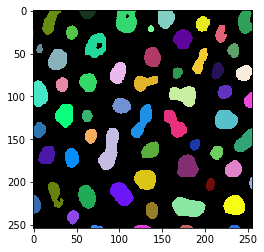

In [3]:
# define features
features = apoc.PredefinedFeatureSet.small_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.medium_dog_log.value + " " + \
           apoc.PredefinedFeatureSet.large_dog_log.value

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter2.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=5,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

## Klassifikatorstatistiken
Nach dem Training können wir einige Statistiken des Klassifikators ausgeben. Es gibt uns eine Tabelle der verwendeten Merkmale und wie wichtig die Merkmale für die Entscheidung der Pixelklassifikation waren.

In [4]:
shares, counts = classifier.statistics()

def colorize(styler):
    styler.background_gradient(axis=None, cmap="rainbow")
    return styler

df = pd.DataFrame(shares).T
df.style.pipe(colorize)

In dieser Visualisierung sehen Sie, dass die Merkmale `gaussian_blur=1`, `difference_of_gaussian=5` und `laplace_box_of_gaussian_blur=5` etwa 65% der Entscheidung ausmachen. Auf der ersten Ebene (Ebene `0`). Wenn diese drei Merkmale entscheidend sind, können wir einen weiteren Klassifikator trainieren, der nur diese Merkmale berücksichtigt. Außerdem sehen wir, dass der Anteil der Merkmale auf den oberen drei Tiefenebenen gleichmäßiger verteilt ist. Diese Ebenen machen möglicherweise keinen großen Unterschied bei der Klassifizierung von Pixeln. Den nächsten Klassifikator, den wir trainieren, können wir mit niedrigerem `max_depth` trainieren.

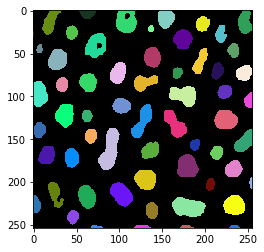

In [5]:
# define features
features = "gaussian_blur=1 difference_of_gaussian=5 laplace_box_of_gaussian_blur=5"

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter3.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

Der neue Klassifikator produziert immer noch ein sehr ähnliches Ergebnis. Er berücksichtigt weniger Merkmale, was ihn schneller macht, aber möglicherweise auch weniger robust gegenüber Unterschieden zwischen Bildern und Aufnahmebedingungen. Wir werfen noch einen Blick auf die Klassifikatorstatistiken:

In [6]:
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

Zu Demonstrationszwecken werden wir nun einen weiteren Klassifikator mit sehr ähnlichen Merkmalen trainieren.

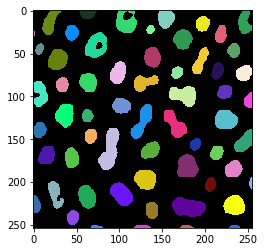

In [7]:
# define features
features = "gaussian_blur=1 difference_of_gaussian=2 difference_of_gaussian=3 difference_of_gaussian=4 difference_of_gaussian=5 difference_of_gaussian=6 laplace_box_of_gaussian_blur=5"

# this is where the model will be saved
cl_filename = '../../data/blobs_object_segmenter3.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.ObjectSegmenter(opencl_filename=cl_filename, 
                           positive_class_identifier=2, 
                           max_depth=3,
                           num_ensembles=1000)
classifier.train(features, manual_annotation, image)

segmentation_result = classifier.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

Auch hier sieht das Segmentierungsergebnis sehr ähnlich aus, aber die Klassifikatorstatistik ist anders.

In [8]:
shares, counts = classifier.statistics()
df = pd.DataFrame(shares).T
df.style.pipe(colorize)

Auf diese Weise kann man auch die Radius- und Sigma-Parameter, die man für die angegebenen Merkmale verwenden muss, feinjustieren. 

Die in diesem Abschnitt gegebenen Hinweise sind keine festen Regeln für die Auswahl der richtigen Merkmale. Die bereitgestellten Tools können jedoch helfen, etwas hinter die Merkmale zu blicken und den Einfluss der bereitgestellten Merkmalslisten und Parameter zu messen.